In [1]:
import numpy as np

Lx = 100.0
Lz = 100.0
nx = 256
nz = 256

In [2]:
S = 3

In [3]:
k0 = 2*np.pi/Lx
kx_zonal = k0*1
kz_zonal = 0

In [4]:
Omega = 1

Pr_exp = np.linspace(0.02, 7, 28)
Pr_array = 10**(-Pr_exp)

r_exp = np.linspace(0.02, 5, 20)
r_array  = 10**(-r_exp)



In [7]:
import time
start_time = time.time()
print("--- %s seconds ---" % (start_time))

ux_uy = np.zeros((Pr_array.shape[0], r_array.shape[0]), dtype=np.float64)
ux_th = np.zeros((Pr_array.shape[0], r_array.shape[0]), dtype=np.float64)

Pr_count = 0
for Pr in Pr_array:
    r_count = 0
    for r in r_array:
    
        R0 = 1 + r*(1/Pr-1)
        kappa_epsqrd = 2*Omega*(2*Omega-S)
        Nsqrd = -kappa_epsqrd*R0
        kappa = np.sqrt(Nsqrd/Pr) #This is because the box size is measured in units of d = (nu*kappa/Nsqrd)^(1/4), see Eq. (5) in https://arxiv.org/pdf/1905.06962.pdf.
        nu = kappa*Pr
        typical_distance_d = (nu*kappa/Nsqrd)**(1/4)
        typical_tau = typical_distance_d**2/kappa


        p1 = lambda kx, kz : k2(kx,kz)*(kappa+2*nu)
        p2 = lambda kx, kz : nu*k2(kx,kz)**2*(2*kappa+nu) + (kappa_epsqrd + Nsqrd)*kz**2/k2(kx,kz)
        p3 = lambda kx, kz : ( nu**2*kappa*k2(kx,kz)**2 + (kappa_epsqrd*kappa+Nsqrd*nu)*kz**2/k2(kx,kz) ) * k2(kx,kz)
        gamma = lambda kx, kz : np.max(np.real(np.roots([1, p1(kx,kz), p2(kx,kz), p3(kx,kz)])))

        f = lambda kx, kz : np.sqrt(k2(kx,kz))/gamma(kx,kz)*np.sqrt(k2(kx,kz))/gamma_nu(kx,kz)*typical_distance_d/typical_tau
        k2 = lambda kx, kz : kx**2+kz**2
        gamma_nu = lambda kx, kz: gamma(kx, kz) + nu*k2(kx, kz)
        gamma_kappa = lambda kx, kz: gamma(kx, kz) + kappa*k2(kx, kz)
        tau_11Z = lambda kx_p, kz_p, kx_pp, kz_pp : (gamma(kx_p,kz_p) + gamma(kx_pp,kz_pp) - nu*k2(kx_zonal,kz_zonal))**(-1)
        C_Z11_symm_k_kp = lambda kx_p, kz_p, kx_pp, kz_pp : 1.0j*( kx_p**2-kx_pp**2 )/(kz_p * f(kx_p, kz_p) * f(kx_pp, kz_pp))
        C_1Z1_symm_kpp_k = lambda kx_p, kz_p, kx_pp, kz_pp : 1.0j*kz_p*f(kx_pp,kz_pp)/f(kx_p,kz_p)*(k2(kx_pp, kz_pp)/kz_pp**2*1/Nsqrd*(1-2*kx_zonal*kx_pp/k2(kx_pp,kz_pp)) 
                                                              + 1/R0*1/gamma_nu(kx_p,kz_p)*1/gamma_nu(kx_pp,kz_pp) - 1/gamma_kappa(kx_p,kz_p)*1/gamma_kappa(kx_pp,kz_pp))/( 
                                                              k2(kx_pp, kz_pp)/kz_pp**2*1/Nsqrd + 1/R0*(1/gamma_nu(kx_pp, kz_pp))**2 - (1/gamma_kappa(kx_pp, kz_pp))**2 )

        ######################################   
        summand_uxuy = 0
        for kx_ppp_ind in range(-int(nx/2), int(nx/2)):
            for kz_ppp_ind in range(-int(nz/2), int(nz/2)):
                kx_ppp = kx_ppp_ind*k0
                kz_ppp = kz_ppp_ind*k0
                if k2(kx_ppp, kz_ppp)!=0:
                    if gamma(kx_ppp, kz_ppp)>0:
                        summand_uxuy += -(2*Omega-S)/gamma_nu(kx_ppp,kz_ppp)*1/(f(kx_ppp,kz_ppp)**2)

        ######################################             
        summand_uxth = 0
        for kx_ppp_ind in range(-int(nx/2), int(nx/2)):
            for kz_ppp_ind in range(-int(nz/2), int(nz/2)):
                kx_ppp = kx_ppp_ind*k0
                kz_ppp = kz_ppp_ind*k0
                if k2(kx_ppp, kz_ppp)!=0:
                    if gamma(kx_ppp, kz_ppp)>0:
                        summand_uxth += -Nsqrd/gamma_kappa(kx_ppp,kz_ppp)*1/(f(kx_ppp,kz_ppp)**2)

        ######################################               
        CCTau = 0
        for kx_p_ind in range(-int(nx/2), int(nx/2)):
            for kz_p_ind in range(-int(nz/2), int(nz/2)):
                kx_p = kx_p_ind*k0
                kz_p = kz_p_ind*k0
                if k2(kx_p, kz_p)!=0:
                    if gamma(kx_p, kz_p)>0:
                        kx_pp = kx_zonal - kx_p
                        kz_pp = kz_zonal - kz_p
                        CCTau += -tau_11Z(kx_p, kz_p, kx_pp, kz_pp) * C_Z11_symm_k_kp(kx_p, kz_p, kx_pp, kz_pp) * C_1Z1_symm_kpp_k(kx_p, kz_p, kx_pp, kz_pp)

        ux_uy[Pr_count, r_count] =  1/np.abs(np.real(CCTau)) * (nu*k2(kx_zonal,kz_zonal)) * summand_uxuy
        ux_th[Pr_count, r_count] =  1/np.abs(np.real(CCTau)) * (nu*k2(kx_zonal,kz_zonal)) * summand_uxth
        print("Pr:%0.10f, r:%0.10f, uxuy:%0.10f" %(Pr, r, ux_uy[Pr_count, r_count]))
        r_count += 1
    
    Pr_count += 1
    
end_time = time.time()
print("--- %s seconds ---" % (end_time))

--- 1702245856.0334623 seconds ---
Pr:0.9549925860, r:0.9549925860, uxuy:0.1636253352
Pr:0.9549925860, r:0.5222695873, uxuy:0.2589965447
Pr:0.9549925860, r:0.2856205648, uxuy:1.4957124757
Pr:0.9549925860, r:0.1562011441, uxuy:2.1017935816
Pr:0.9549925860, r:0.0854238119, uxuy:1.9647514692
Pr:0.9549925860, r:0.0467168643, uxuy:2.5907838755
Pr:0.9549925860, r:0.0255486773, uxuy:4.1402411705
Pr:0.9549925860, r:0.0139721474, uxuy:21.1677934285
Pr:0.9549925860, r:0.0076411354, uxuy:0.1939201485
Pr:0.9549925860, r:0.0041788101, uxuy:1.4588071014
Pr:0.9549925860, r:0.0022853218, uxuy:1.8290152582
Pr:0.9549925860, r:0.0012498046, uxuy:1.9875027657
Pr:0.9549925860, r:0.0006834974, uxuy:2.0647704475
Pr:0.9549925860, r:0.0003737934, uxuy:2.1046430983
Pr:0.9549925860, r:0.0002044214, uxuy:2.1257948049
Pr:0.9549925860, r:0.0001117947, uxuy:2.1371755293
Pr:0.9549925860, r:0.0000611386, uxuy:2.1433449635
Pr:0.9549925860, r:0.0000334357, uxuy:2.1467028446
Pr:0.9549925860, r:0.0000182854, uxuy:2.148534

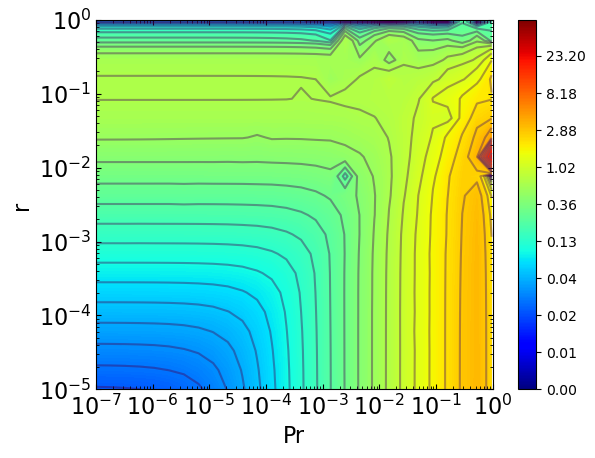

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm

levels = MaxNLocator(nbins=15).tick_values(ux_uy.min(), ux_uy.max())

fnt = 16

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.

Z = ux_uy
fig, ax = plt.subplots(nrows=1)

lev_exp = np.arange(np.floor(np.log2(Z.min())-1), np.ceil(np.log2(Z.max())+1), 8*1e-3)
levs = np.power(2, lev_exp)

lev_exp2 = np.arange(np.floor(np.log2(Z.min())-1), np.ceil(np.log2(Z.max())+1), 400*1e-3)
levs2 = np.power(2, lev_exp2)
im = ax.contourf(Pr_array, r_array, Z.T, levels=levs,cmap=plt.cm.jet,norm = LogNorm())
im2 = ax.contour(Pr_array, r_array, Z.T, levels=levs2, alpha=0.4)
#im = ax.contourf(Pr_array, r_array, Z.T, cmap='RdBu_r', levels=20)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("Pr", fontsize=fnt)
ax.set_ylabel("r", fontsize=fnt)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize=fnt, top=True, right=True, bottom=True, left=True)

## set y ticks
x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 8)
ax.xaxis.set_major_locator(x_major)
x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 16)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(-7)])
ax.set_xticklabels([r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{-7}$"], fontsize=fnt, color='black', zorder=100)


## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 8)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 16)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_yticks([10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0)])
ax.set_yticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=fnt, color='black', zorder=100)


fig.colorbar(im, ax=ax)

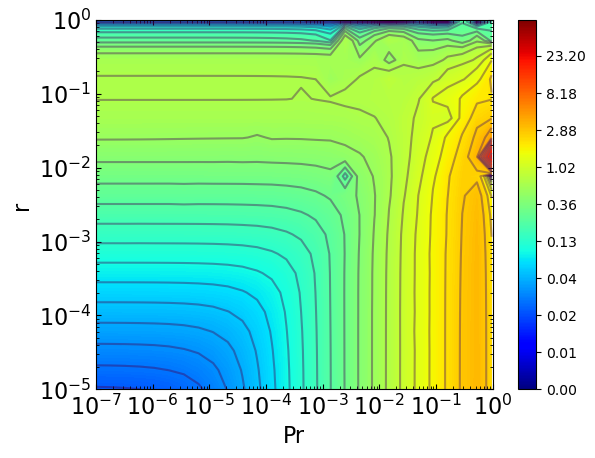

In [10]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib import cm, ticker
from matplotlib.colors import LogNorm

levels = MaxNLocator(nbins=15).tick_values(ux_uy.min(), ux_uy.max())

fnt = 16

# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.

Z = ux_uy
fig, ax = plt.subplots(nrows=1)

lev_exp = np.arange(np.floor(np.log2(Z.min())-1), np.ceil(np.log2(Z.max())+1), 8*1e-3)
levs = np.power(2, lev_exp)

lev_exp2 = np.arange(np.floor(np.log2(Z.min())-1), np.ceil(np.log2(Z.max())+1), 400*1e-3)
levs2 = np.power(2, lev_exp2)
im = ax.contourf(Pr_array, r_array, Z.T, levels=levs,cmap=plt.cm.jet,norm = LogNorm())
im2 = ax.contour(Pr_array, r_array, Z.T, levels=levs2, alpha=0.4)
#im = ax.contourf(Pr_array, r_array, Z.T, cmap='RdBu_r', levels=20)
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("Pr", fontsize=fnt)
ax.set_ylabel("r", fontsize=fnt)
ax.tick_params(axis = 'both', which = 'both', direction = 'in', labelsize=fnt, top=True, right=True, bottom=True, left=True)

## set y ticks
x_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 8)
ax.xaxis.set_major_locator(x_major)
x_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 16)
ax.xaxis.set_minor_locator(x_minor)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([10**(-6), 10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0), 10**(-7)])
ax.set_xticklabels([r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$", r"$10^{-7}$"], fontsize=fnt, color='black', zorder=100)


## set y ticks
y_major = matplotlib.ticker.LogLocator(base = 10.0, numticks = 8)
ax.yaxis.set_major_locator(y_major)
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 16)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_yticks([10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 10**(0)])
ax.set_yticklabels([r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", r"$10^{0}$"], fontsize=fnt, color='black', zorder=100)


fig.colorbar(im, ax=ax)

In [12]:
# import h5py

# #saving betas energy norm used ones
# # import time
# # import shutil, os 
# # access_rights = 0o755
# # try:
# #     os.mkdir(path, access_rights)
# # except OSError:
# #     print ("")
# # else:
# #     print("Successfully created the directory %s" %(path))

# ####################
# hf = h5py.File('GSF_fig5_r_Pr_scan__Shear_eq_%0.2f_new.h5' %(S), 'w')

# g2 = hf.create_group('ux_uy')
# g21 = hf.create_group('ux_uy/ux_uy')
# g21.create_dataset('ux_uy',data=ux_uy)

# g4 = hf.create_group('ux_th')
# g41 = hf.create_group('ux_th/ux_th')
# g41.create_dataset('ux_th',data=ux_th)

# hf.close()

In [11]:
pwd

'/home/x-btripathi/ALL_work_on_ONDEMAND/GSF/new/after_referee_report/data_for_figures/fig4_analytical_work_coded/GSF_fig5_r_Pr_scan_data'

In [12]:
import h5py
hf = h5py.File('GSF_fig5_r_Pr_scan__Shear_eq_%0.2f.h5' %(S), 'r')
ux_uy = hf['ux_uy/ux_uy/ux_uy'][()]
ux_th = hf['ux_th/ux_th/ux_th'][()]
